In [130]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## Let's get some data...

In [132]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [133]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)
print("x_test is shape ",len(x_test))

x_test is shape  10000


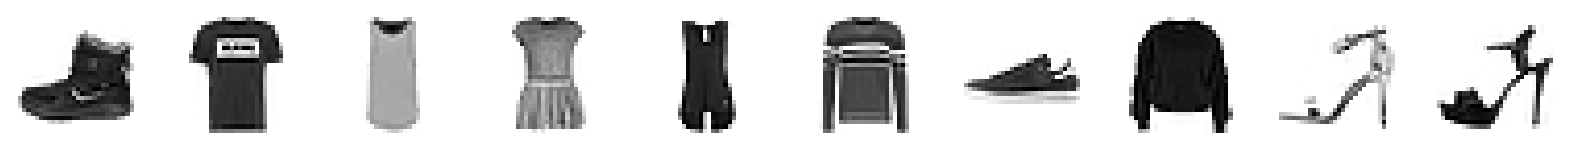

In [111]:
## Let's show some clothing options
display(x_train)

## Some key points

Alright, one of the points of the Variational Autoencoder, is filtering the encoding 
To normalize the latent space. In other words, we want to normalize the data as best 
we can to ensure we don't have huge gaps in the latent space -- where we do the
interpolating. This provides better results, both to spread out dense data and to shore
up places where we might lacking. 

Of course if there are substantial gaps, then there's not a lot that can be done. The model
will have problems generating suitable variety of items (clothing images, faces, etc.). But 
in theory, this step ought to help.

In [112]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Notice the z_mean + tf.exp(0.5...) This is the gaussian distribution -- to normalize the inputs
# smoothing them out.


## Building the encoder

In [113]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_25 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_24[0][0]']           
                                                                                                  
 conv2d_26 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_25[0][0]']           
                                                                                            

## And the decoder

In [114]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_24 (Conv2  (None, 8, 8, 128)         147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_25 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_26 (Conv2  (None, 32, 32, 32)        1846

## Building the VAE class

In [115]:
class VAE(models.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self,inputs):
        """Call the model on an input"""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self,data):
        """Step run during training. """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients( zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """run a step during validation"""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
        

### WHat is KL Divergence
KL divergence is a way of measuring how much one probability distribution differs from another.

Previously, our loss function only consisted of the reconstruction loss between images and their attempted copies after being passed through the encoder and decoder. The reconstruction loss also appears in a variational autoencoder, but we now require one extra component: the Kullback–Leibler (KL) divergence term.

In summary, the KL divergence term penalizes the network for encoding observations to z_mean and z_log_var variables that differ significantly from the parameters of a standard normal distribution, namely z_mean = 0 and z_log_var = 0.

Why does this addition to the loss function help?

Firstly, we now have a well-defined distribution that we can use for choosing points in the latent space—the standard normal distribution. Secondly, since this term tries to force all encoded distributions toward the standard normal distribution, there is less chance that large gaps will form between point clusters. Instead, the encoder will try to use the space around the origin symmetrically and efficiently.

In the original VAE paper, the loss function for a VAE was simply the addition of the reconstruction loss and the KL divergence loss term. A variant on this (the -VAE) includes a factor that weights the KL divergence to ensure that it is well balanced with the reconstruction loss. If we weight the reconstruction loss too heavily, the KL loss will not have the desired regulatory effect and we will see the same problems that we experienced with the plain autoencoder. If the KL divergence term is weighted too heavily, the KL divergence loss will dominate and the reconstructed images will be poor. This weighting term is one of the parameters to tune when you’re training your VAE.


In [134]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)

vae.compile(optimizer=optimizer)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

print("x_test len is ",len(x_test))

Epoch 1/5
600/600 [==============================] - ETA: 0s - total_loss: 132.3607 - reconstruction_loss: 127.3189 - kl_loss: 5.0418WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 34s 57ms/step - total_loss: 132.3607 - reconstruction_loss: 127.3189 - kl_loss: 5.0418 - val_loss: 135.0340 - val_reconstruction_loss: 129.7205 - val_kl_loss: 5.3135
Epoch 2/5
600/600 [==============================] - ETA: 0s - total_loss: 132.0148 - reconstruction_loss: 126.9421 - kl_loss: 5.0726WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 44s 74ms/step - total_loss: 132.0148 - reconstruction_loss: 126.9421 - kl_loss: 5.0726 - val_loss: 134.9249 - val_reconstruction_loss: 129.7631 - val_kl_loss: 5.1618
Epoch 3/5
600/600 [==============================] - ETA: 0s - total_loss: 131.7216 - reconstruction_loss: 126.6268 - kl_loss: 5.0948WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 43s 72ms/step - total_loss: 131.7216 - reconstruction_loss: 126.6268 - kl_loss: 5.0948 - val_loss: 135.6420 - val_reconstruction_loss: 130.5393 - val_kl_loss: 5.1027
Epoch 4/5
600/600 [==============================] - ETA: 0s - total_loss: 131.5213 - reconstruction_loss: 126.4055 - kl_loss: 5.1158WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 49s 81ms/step - total_loss: 131.5213 - reconstruction_loss: 126.4055 - kl_loss: 5.1158 - val_loss: 134.6363 - val_reconstruction_loss: 129.3872 - val_kl_loss: 5.2491
Epoch 5/5
600/600 [==============================] - ETA: 0s - total_loss: 131.2746 - reconstruction_loss: 126.1324 - kl_loss: 5.1422WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 45s 75ms/step - total_loss: 131.2746 - reconstruction_loss: 126.1324 - kl_loss: 5.1422 - val_loss: 134.1782 - val_reconstruction_loss: 128.8373 - val_kl_loss: 5.3409
x_test len is  10000


In [117]:
# Save the final model
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/encoder")


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


### Time to reconstruct images using the VAE

example labels is shape  (5000, 32, 32, 1)
157/157 [==============================] - 1s 8ms/step
Example real clothing items


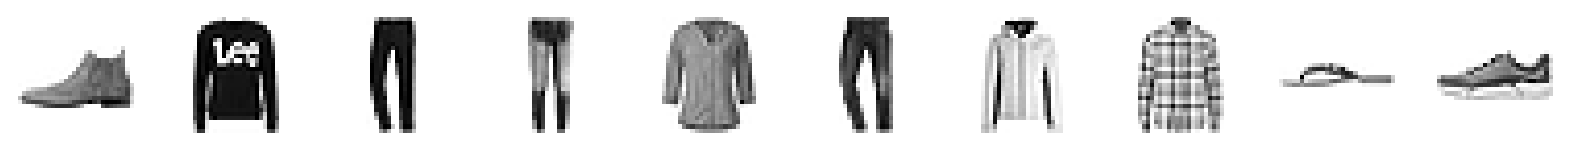

Reconstructions


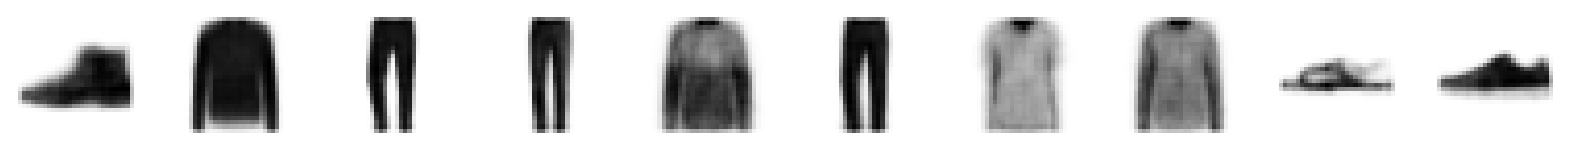

In [135]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = x_test[:n_to_predict]

print("x_test is shape ", x_test.shape)
print("example labels is shape ",example_labels.shape)

# use the VAE
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## Embeddings (the latest space) via the Encodere
Let's take a look at the latent space

In [119]:
z_mean, z_var, z = encoder.predict(example_images)
# examples of this are:
print(z[:10])

157/157 [==============================] - 0s 2ms/step
[[ 1.1959032   1.2154403 ]
 [-0.8944431  -0.12359113]
 [-0.79417646 -2.7091544 ]
 [ 0.5275935  -2.1813889 ]
 [ 0.01954408 -0.07772373]
 [-0.56557184 -1.4859083 ]
 [ 1.097614   -0.53434163]
 [ 0.29027247 -0.23085836]
 [ 1.1505573   2.973956  ]
 [-0.12118933  2.2229934 ]]


Showing the encodings (latest space) in 2-D

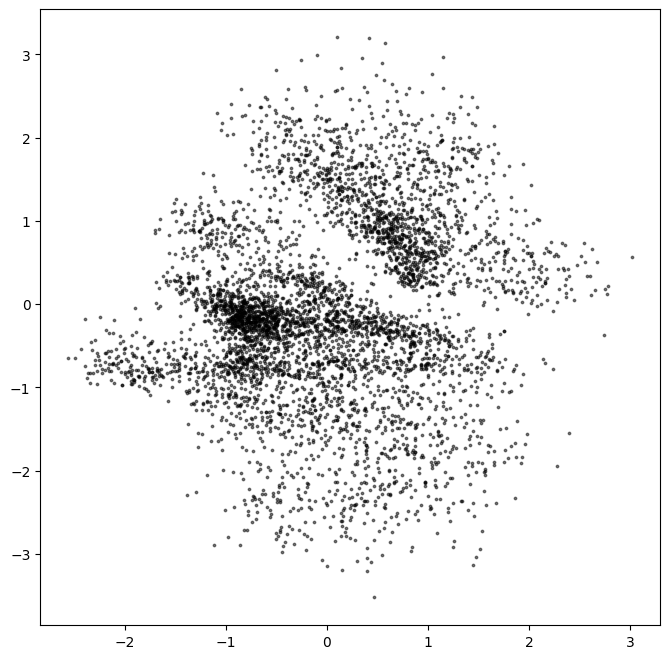

In [120]:
figsize=8
plt.figure(figsize=(figsize,figsize))
plt.scatter(z[:,0], z[:,1], c="black", alpha=0.5, s=3)
plt.show()

## Now generate novel images using the decoder.
Since our latent space is relatively well filled out, let's generate some images!

In [121]:
grid_width, grid_height = (6,3) # number of samples essentially
z_sample = np.random.normal(size=(grid_width * grid_height,2))
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 47ms/step


## Convert original embeddings and the sampled embeddings to p-values

Recall: P-value help to determine how likely it is to get a particular result when the null hypothesis is assumed to be true. Therefore, if the null hypothesis is assumed to be true, the p-value gives us an estimate of how “strange” our sample is. If the p-value is very small (<0.05 is considered generally), then our sample is “strange,” and this means that our assumption that the null hypothesis is correct is most likely to be false. Thus, we reject it.

In [122]:
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)


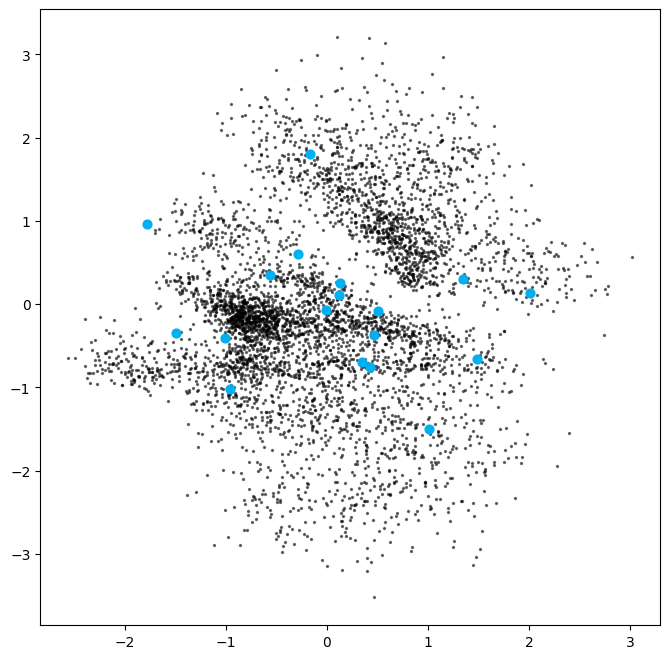

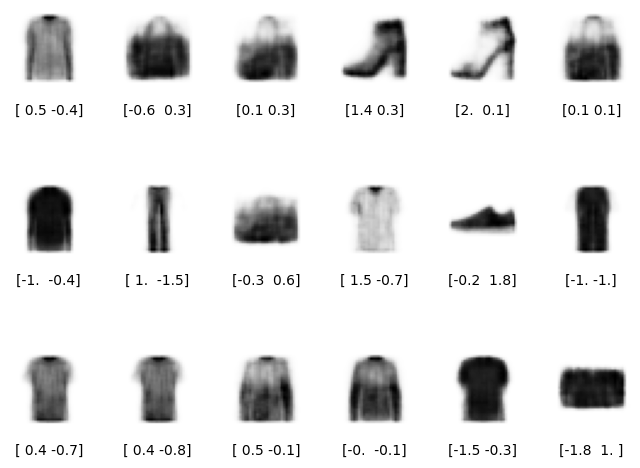

In [123]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## Full exploration of the latent space

example labels is shape  (5000, 32, 32, 1)


ValueError: 'c' argument has 5120000 elements, which is inconsistent with 'x' and 'y' with size 5000.

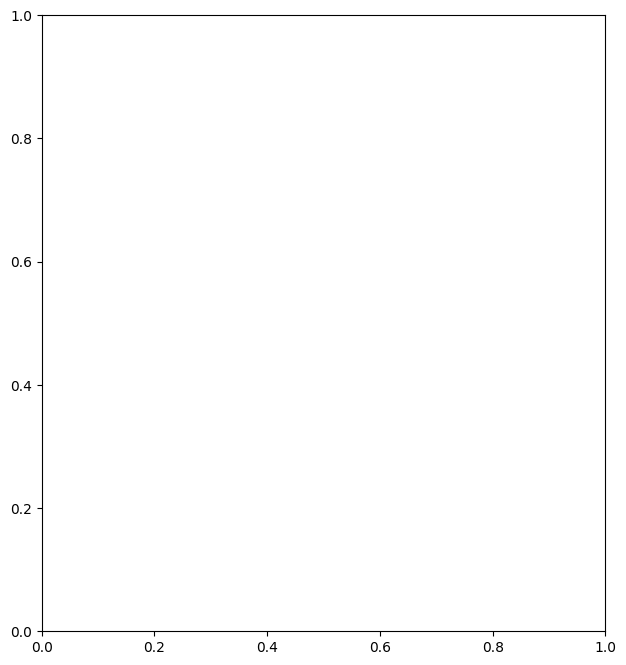

In [127]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
print("example labels is shape ",example_labels.shape)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")